In [1]:
from __future__ import print_function

import numpy as np

import tensorflow as tf
from lstm import model
import pickle

In [2]:
DEBUG = False
PLOTTING_SUPPORT = True
RUN_AS_PY_SCRIPT = False
SET_EULER_PARAMS = False
SET_MARMOT_PARAMS = False

# Handle arguments (When executed as .py script)
import sys
argv = sys.argv[:]
if len(argv) > 1:
  script_path = argv.pop(0)
  if "--euler" in argv:
    import sys
    sys.stdout = open('stdout.txt', 'w')
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    SET_EULER_PARAMS = True
    print("Parameters set for execution on euler cluster")
    argv.remove("--euler")
  if "--marmot" in argv:
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    SET_MARMOT_PARAMS = True
    print("Parameters set for execution on marmot cluster")
    argv.remove("--marmot") 

In [3]:
if not RUN_AS_PY_SCRIPT:
  %load_ext autoreload
  %autoreload 2
  from IPython.display import clear_output
  if PLOTTING_SUPPORT:
    %matplotlib notebook
    from matplotlib import pyplot as plt
    plotting_function = plt.step

## Parameters

In [4]:
BATCH_SIZE = 100

MAX_STEPS = 10000
VAL_EVERY_N_STEPS = 1
VAL_STEP_TOLERANCE = 3

MP = model.ModelParams()

DATA_DIR = "/home/daniel/Downloads/Raw-Waves/"
DATA_FILENAME="001_Session1_FilterTrigCh_RawCh.mat"
DATA2_FILENAME="001_Session2_FilterTrigCh_RawCh.mat"
DATA3_FILENAME="034_Session1_FilterTrigCh_RawCh.mat"
SAMPLING = 1
MAX_VAL_DATA_LENGTH = 100000000
MAX_TRAIN_DATA_LENGTH = 400000000
TINY_DATASET = False
FILTER_IN_SLEEP_WAVES = True

RESTORE_MODEL = True
SAVE_DIR = "/home/daniel/Desktop/lstm/"
SAVE_FILE = "model.checkpoint"
MP_FILENAME = "model_params.pckl"
TENSORBOARD_DIR = "/home/daniel/tensorboard"
SAVE_UNVALIDATED = False
DETAILED_STEP_TIMES = True
PROGRESS = True

In [5]:
if SET_EULER_PARAMS:
    DATA_DIR = "/cluster/home/dugasd/Raw-Waves/"
    SAVE_DIR = "/cluster/home/dugasd/lstm-euler/"
    TENSORBOARD_DIR = None
    
    MAX_STEPS = 1000000
    VAL_STEP_TOLERANCE = 5

if SET_MARMOT_PARAMS:
    DATA_DIR = "/home/daniel/Raw-Waves/"
    SAVE_DIR = "/home/daniel/lstm-marmot/"
    TENSORBOARD_DIR = None
    
    MAX_STEPS = 1000000
    VAL_STEP_TOLERANCE = 10
    
if not RUN_AS_PY_SCRIPT:
    #MAX_STEPS = 0
    VAL_STEP_TOLERANCE = 10
    MP.QUANTIZATION = 10
    MP.HIDDEN_LAYERS = [{'shape': [100]}, {'shape': [20]}]
    TINY_DATASET = True

In [6]:
if RUN_AS_PY_SCRIPT:
  while argv:
      arg = argv.pop(0)
      if arg == "-VAL_STEP_TOLERANCE":
        VAL_STEP_TOLERANCE = int(argv.pop(0))
        print("VAL_STEP_TOLERANCE set to " + str(VAL_STEP_TOLERANCE))
      elif arg == "-SAVE_DIR":
        SAVE_DIR = argv.pop(0)
        print("SAVE_DIR set to " + SAVE_DIR)
      elif arg == "-CLIP_GRADIENTS":
        MP.CLIP_GRADIENTS = float(argv.pop(0))
        print("CLIP_GRADIENTS set to " + str(MP.CLIP_GRADIENTS))
      elif arg == "--float64":
        MP.FLOAT_TYPE = tf.float64
        print("MP.FLOAT_TYPE set to " + str(MP.FLOAT_TYPE))
      else:
        print("Unknown argument: " + arg)

In [7]:
SAVE_PATH = SAVE_DIR+SAVE_FILE
if SAVE_UNVALIDATED:
  SAVE_DIR_NOVAL = SAVE_DIR+"unvalidated/"
  SAVE_PATH_NOVAL = SAVE_DIR_NOVAL+SAVE_FILE

## Datasets

In [8]:
if True:
  raw_wave = []

  import scipy.io
  mat = scipy.io.loadmat(DATA_DIR+DATA_FILENAME)
  raw_wave = mat.get('data')[0]
  raw_wave = raw_wave[::SAMPLING]
  raw_wave = raw_wave/100 # volts -> microvolts
  raw_wave[np.where(raw_wave>1)] = 1
  raw_wave[np.where(raw_wave<-1)] = -1
  wave_indices = mat.get('wave')[0].astype(int)
    
  # Save some memory
  del mat

In [9]:
is_sleep_wave = np.zeros(raw_wave.shape)
for i in range(wave_indices.shape[1]):
  is_sleep_wave[wave_indices[0,i]:wave_indices[4,i]] = 1

example_contains_sw = np.zeros(raw_wave.shape)
for i in range(wave_indices.shape[1]):
  example_contains_sw[wave_indices[0,i]-MP.WAVE_OUT_SHAPE[0]:wave_indices[4,i]+MP.WAVE_OUT_SHAPE[0]] = 1
example_contains_sw = example_contains_sw[MP.WAVE_IN_SHAPE[0]:].astype(bool)

In [10]:
if TINY_DATASET:
  raw_wave = raw_wave[np.where(example_contains_sw)[0][0]:][:10000]
  is_sleep_wave = is_sleep_wave[np.where(example_contains_sw)[0][0]:][:10000]
  example_contains_sw = example_contains_sw[np.where(example_contains_sw)[0][0]:][:10000]

<IPython.core.display.Javascript object>


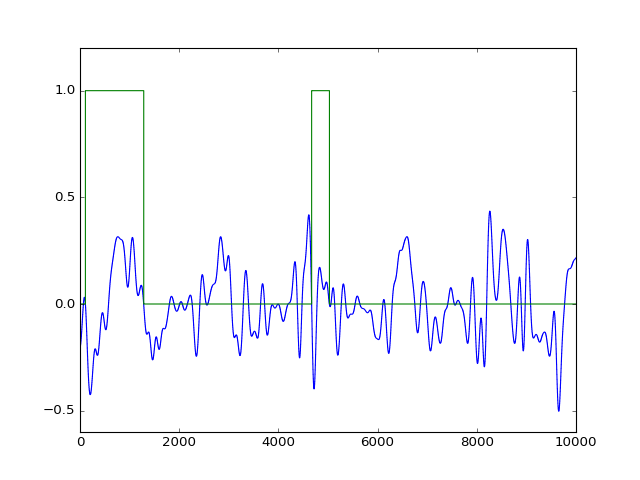

In [11]:
if not RUN_AS_PY_SCRIPT:
  plt.figure()
  plotting_function(range(len(raw_wave)),raw_wave,label="raw_wave")
  plotting_function(range(len(is_sleep_wave)), is_sleep_wave, label="is_sleep_wave")
  plt.show()

## Create Model

In [45]:
if not RUN_AS_PY_SCRIPT:
  try:
    stored_MP = pickle.load(open(SAVE_DIR+MP_FILENAME, 'rb'))
    MP = stored_MP
    print("Set params for compatibility with stored model.")
  except FileNotFoundError:
    print("No stored model found.")

Set params for compatibility with stored model.


In [12]:
lstm = model.LSTM(MP)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [14]:
if False and TENSORBOARD_DIR != None:
  summary_writer = tf.train.SummaryWriter(TENSORBOARD_DIR, lstm.sess.graph)

In [48]:
if RESTORE_MODEL:
  try:
    lstm.saver.restore(lstm.sess, SAVE_PATH)
    print("Model restored.")
  except:
    print("Could not load model: ", end="")
    try:
      stored_MP = pickle.load(open(SAVE_DIR+MP_FILENAME, 'rb'))
      print("mismatch between model params.")
      print("Stored model: "); print(stored_MP); print("New model: "); print(MP)
    except:
      print("no model folder.")

Model restored.


## Create Training Data

In [15]:
## Split into training and val data
split_at = min(MAX_VAL_DATA_LENGTH, int(0.2 * len(raw_wave)))
val = raw_wave[:split_at]
val_is_sleep = is_sleep_wave[:split_at]
train = raw_wave[split_at:][:MAX_TRAIN_DATA_LENGTH]
train_is_sleep = is_sleep_wave[split_at:][:MAX_TRAIN_DATA_LENGTH]

In [16]:
if FILTER_IN_SLEEP_WAVES:
  val_contains_sw = example_contains_sw[:split_at]
  train_contains_sw = example_contains_sw[split_at:][:MAX_TRAIN_DATA_LENGTH]
else:
  val_contains_sw = None
  train_contains_sw = None

## Train Model ( Computationally Intensive )

In [ ]:
from timeit import default_timer as timer
from lstm.batchmaker import Batchmaker, progress_bar
progress_bar('reset')

total_step_cost = None
step_cost_log = []
total_val_cost = 0
val_steps_since_last_improvement = 0
step_start = timer()

try:
    val_cost_log = list(np.loadtxt(SAVE_DIR+"val_cost_log.txt"))
    print("Previous cost log found.")
except:
    val_cost_log = []
    
print("Training started.")
for step in range(MAX_STEPS):
  # Validation
  val_batchmaker = Batchmaker(val, val_is_sleep, BATCH_SIZE, MP, example_filter=val_contains_sw)
  if np.mod(step, VAL_EVERY_N_STEPS) == 0:
    total_val_cost = 0
    while True:
      if val_batchmaker.is_depleted():
        break
      else:
        batch_input_values, batch_target_values, batch_is_sleep_values = val_batchmaker.next_batch()
        cost_value = lstm.cost_on_single_batch(batch_input_values, batch_target_values, batch_is_sleep_values)
        total_val_cost += cost_value
        if PROGRESS:
          progress_bar(val_batchmaker)
    print("Validation cost: "+str(total_val_cost)+"  (Training cost: "+str(total_step_cost)+")", end="")
    try:
      print(" Step Time: " + str(step_end-step_start))
      if DETAILED_STEP_TIMES:
        print(step_times)
    except: 
        print(" ")
    
    val_cost_log.append(total_val_cost)
    
    # Training Monitor
    if len(val_cost_log) > 1:
        # Save cost log.
        import os
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
            if SAVE_UNVALIDATED: os.makedirs(SAVE_DIR_NOVAL)
            print("Created directory: %s" % SAVE_DIR)
            with open(SAVE_DIR+MP_FILENAME, 'wb') as file:
              pickle.dump(MP, file, protocol=2)
        np.savetxt(SAVE_DIR+"val_cost_log.txt", val_cost_log)
        # Save if cost has improved. Otherwise increment counter.
        if val_cost_log[-1] <  min(val_cost_log[:-1]):
            val_steps_since_last_improvement = 0
            # save model to disk
            print("Saving ... ", end='')
            save_path = lstm.saver.save(lstm.sess, SAVE_PATH)
            print("Model saved in file: %s" % save_path)      
        else:
            val_steps_since_last_improvement += 1  
    # Stop training if val_cost hasn't improved in VAL_STEP_TOLERANCE steps
    if val_steps_since_last_improvement > VAL_STEP_TOLERANCE:
        if SAVE_UNVALIDATED:
            print("Saving ... ", end='')
            save_path = lstm.saver.save(lstm.sess, SAVE_PATH_NOVAL)
            print("Unvalidated model saved in file: %s" % save_path)
        print("Training stopped by validation monitor.")
        break
            
  # Train on batches
  step_start = timer()
  zero = timer() - timer()
  step_times = {'batchmaking': zero, 'training': zero, 'plotting': zero}
  total_step_cost = 0
  training_batchmaker = Batchmaker(train, train_is_sleep, BATCH_SIZE, MP, example_filter=train_contains_sw)
  while True:
    if training_batchmaker.is_depleted():
      break
    else:
      t_a = timer()  
      batch_input_values, batch_target_values, batch_is_sleep_values = training_batchmaker.next_batch()
      t_b = timer()
      # Train over 1 batch.
      cost_value = lstm.train_on_single_batch(batch_input_values, batch_target_values, batch_is_sleep_values)
      total_step_cost += cost_value
      t_c = timer()
      if PROGRESS:
        progress_bar(training_batchmaker)
      t_d = timer()
      step_times['batchmaking'] += t_b - t_a
      step_times['training']    += t_c - t_b
      step_times['plotting']    += t_d - t_c
  step_cost_log.append(total_step_cost)
  step_end = timer()


print("Training ended.")

Training started.
Validation cost: 761.651580269  (Training cost: None) 
Validation cost: 732.520678416  (Training cost: 207.194969537) Step Time: 10.76013079400036
{'plotting': 0.0005654759997923975, 'training': 10.735971127000994, 'batchmaking': 0.0017578209999555838}
Created directory: /home/daniel/Desktop/feedforward/
Saving ... 

## Evaluation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


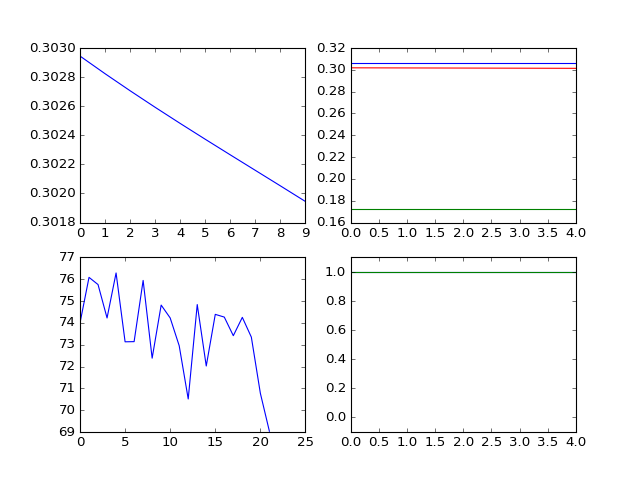

KeyboardInterrupt: 

In [54]:
if not RUN_AS_PY_SCRIPT:
  plt.close('all')
  import time
  from lstm.batchmaker import Batchmaker
  
  total_step_cost = None
  step_cost_log = []

  # single step
  while True:
      # Validation
      test_batchmaker = Batchmaker(val, val_is_sleep, 1, MP, example_filter=val_contains_sw, shuffle_examples=True)
      X, Y, IS = test_batchmaker.next_batch()
      Y_pred, IS_pred = lstm.predict(X)
      from lstm.quantize import *
      plt.clf()
      plt.figure('training_evo')
      plt.subplot(2,2,1)
      plt.plot(X[0])
      plt.subplot(2,2,2)
      y = inverse_mu_law(unquantize(quantize(mu_law(Y[0]),MP.ESTIMATOR['bins'])))
      plt.step(range(len(y)), y, label='ground truth')
      y = inverse_mu_law(unquantize(pick_max(Y_pred[0])))
      plt.step(range(len(y)), y, label='prediction')
      plt.plot(Y[0])
      plt.subplot(2,2,4)
      plt.step(range(len(IS[0])), IS[0], label='ground truth')
      plt.step(range(len(IS_pred[0])), IS_pred[0], label='prediction')
      plt.ylim([-0.1, 1.1])
      plt.subplot(2,2,3)
      plt.plot(step_cost_log)
      plt.show()
      plt.gcf().canvas.draw()
      time.sleep(0.1)
    
      # Train on batches
      total_step_cost = 0
      training_batchmaker = Batchmaker(train, train_is_sleep, BATCH_SIZE, MP, example_filter=train_contains_sw)
      while True:
        if training_batchmaker.is_depleted():
          break
        else:
          batch_input_values, batch_target_values, batch_is_sleep_values = training_batchmaker.next_batch()
          # Train over 1 batch.
          cost_value = lstm.train_on_single_batch(batch_input_values, batch_target_values, batch_is_sleep_values)
          total_step_cost += cost_value
      step_cost_log.append(total_step_cost)